Author: Elizabeth Luong

Date: 5 February 2025

## Q1

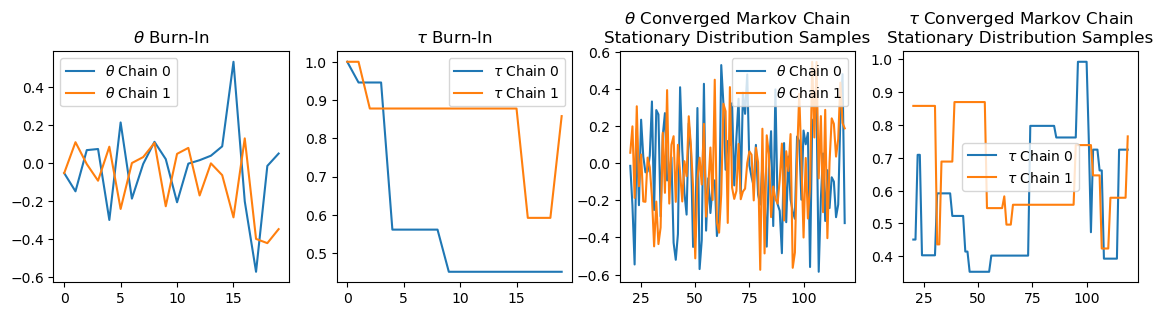

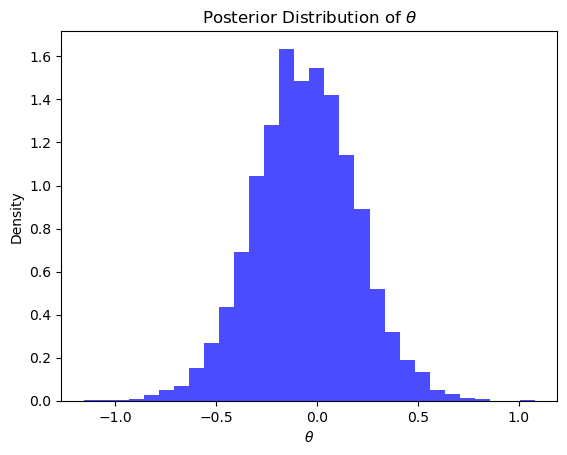

95% credible interval for θ: [-0.553411   0.4394931]


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def fixed_metropolis_within_gibbs_sampler(n, m, s, C=2, G=5000, burn_in=20):
    x = stats.norm(loc=m, scale=s).rvs(size=n)
    theta, tau = np.zeros([C, G]), np.full([C, G], 1.0)  # Initialize tau with positive values
    theta[:, 0] = np.mean(x)  # Initialization

    for c in range(C):
        for g in range(1, G):
            # Target distribution (log-scale for stability)
            def log_tau_target(tau_):
                if tau_ <= 0:
                    return -np.inf  # Invalid tau
                log_likelihood = np.sum(stats.norm(loc=theta[c, g-1], scale=1/np.sqrt(tau_)).logpdf(x))
                log_prior = stats.expon(scale=1).logpdf(tau_)
                return log_likelihood + log_prior

            # Proposal distribution for τ
            tau_proposal = stats.expon(scale=2)
            tau_tilde = tau_proposal.rvs()

            # Metropolis-Hastings acceptance probability (log-scale)
            log_mh_ratio = (log_tau_target(tau_tilde) - log_tau_target(tau[c, g-1])) + \
                           (tau_proposal.logpdf(tau[c, g-1]) - tau_proposal.logpdf(tau_tilde))
            acceptance_probability = min(1, np.exp(log_mh_ratio))

            if stats.uniform().rvs() < acceptance_probability:
                tau[c, g] = tau_tilde
            else:
                tau[c, g] = tau[c, g-1]

            # Updating θ based on the joint distribution (assuming normal prior)
            theta_mean = np.mean(x)
            theta_std = (1 / (tau[c, g] * n)) ** 0.5
            theta[c, g] = stats.norm(loc=theta_mean, scale=theta_std).rvs()

    # Visualization
    fig, ax = plt.subplots(1, 4, figsize=(14, 3))
    ax[0].set_title("$\\theta$ Burn-In")
    ax[1].set_title("$\\tau$ Burn-In")
    ax[2].set_title("$\\theta$ Converged Markov Chain\nStationary Distribution Samples")
    ax[3].set_title("$\\tau$ Converged Markov Chain\nStationary Distribution Samples")

    demo = 120
    for c in range(C):
        ax[0].plot(theta[c, :burn_in], label=f"$\\theta$ Chain {c}")
        ax[1].plot(tau[c, :burn_in], label=f"$\\tau$ Chain {c}")
        ax[2].plot(np.arange(burn_in, demo), theta[c, burn_in:demo], label=f"$\\theta$ Chain {c}")
        ax[3].plot(np.arange(burn_in, demo), tau[c, burn_in:demo], label=f"$\\tau$ Chain {c}")

    ax[0].legend()
    ax[1].legend()
    ax[2].legend()
    ax[3].legend()
    plt.show()

    plt.hist(theta[0, burn_in:], bins=30, density=True, alpha=0.7, color='blue')
    plt.title("Posterior Distribution of $\\theta$")
    plt.xlabel("$\\theta$")
    plt.ylabel("Density")
    plt.show()

    # 95% credible interval for θ
    credible_interval = np.quantile(theta[0, burn_in:], [0.025, 0.975])
    print(f"95% credible interval for θ: {credible_interval}")

# Run the sampler
fixed_metropolis_within_gibbs_sampler(n=30, m=0, s=1)

To demonstrate the Bayesian inference using the optimized Metropolis within Gibbs sampler, we will demonstrate how changing the prior hyperparameters influences the posterior distributions relative to the sample and the likelihood under varying prior hyperparameters.

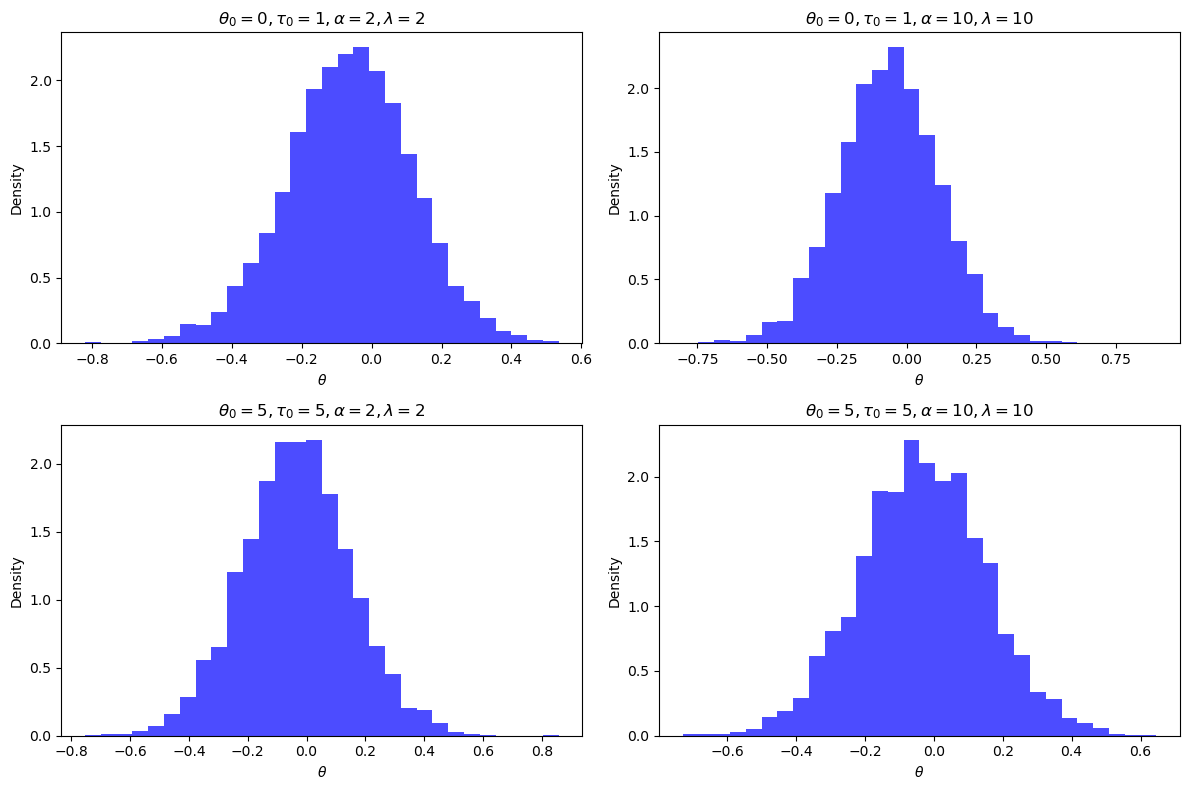

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def optimized_metropolis_within_gibbs_sampler(n, m, s, theta_0_list, tau_0_list, alpha_list, lambd_list, C=2, G=5000, burn_in=500):
    """
    Optimized Metropolis within Gibbs sampler for Normal-Gamma model with different prior hyperparameters to analyze their effect.
    """

    x = stats.norm(loc=m, scale=s).rvs(size=n) 

    fig, axes = plt.subplots(len(theta_0_list), len(alpha_list), figsize=(12, 8))

    for i, (theta_0, tau_0) in enumerate(zip(theta_0_list, tau_0_list)):
        for j, (alpha, lambd) in enumerate(zip(alpha_list, lambd_list)):

            theta, tau = np.zeros([C, G]), np.zeros([C, G])
            theta[:, 0] = np.mean(x)
            tau[:, 0] = 1.0  # Initialize tau with a positive value

            for c in range(C):
                for g in range(1, G):
                    # Metropolis-Hastings step for tau
                    tau_current = tau[c, g-1]
                    tau_proposal = stats.gamma(a=2, scale=1).rvs()  # Proposal distribution

                    log_target_current = np.sum(stats.norm(loc=theta[c, g-1], scale=1/np.sqrt(tau_current)).logpdf(x)) \
                                         + stats.gamma(a=alpha/2, scale=2/lambd).logpdf(tau_current)
                    log_target_proposal = np.sum(stats.norm(loc=theta[c, g-1], scale=1/np.sqrt(tau_proposal)).logpdf(x)) \
                                          + stats.gamma(a=alpha/2, scale=2/lambd).logpdf(tau_proposal)

                    log_acceptance_ratio = log_target_proposal - log_target_current
                    acceptance_prob = min(1, np.exp(log_acceptance_ratio))

                    tau[c, g] = tau_proposal if np.random.rand() < acceptance_prob else tau_current

                    # Gibbs step for theta
                    mean_posterior = (n * np.mean(x) + theta_0 / tau_0) / (n + 1 / tau_0)
                    std_posterior = (1 / (tau[c, g] * (n + 1 / tau_0)))**0.5
                    theta[c, g] = stats.norm(loc=mean_posterior, scale=std_posterior).rvs()

            axes[i, j].hist(theta[0, burn_in:], bins=30, density=True, alpha=0.7, color='blue')
            axes[i, j].set_title(f"$\\theta_0={theta_0}, \\tau_0={tau_0}, \\alpha={alpha}, \\lambda={lambd}$")
            axes[i, j].set_xlabel("$\\theta$")
            axes[i, j].set_ylabel("Density")

    plt.tight_layout()
    plt.show()

# Run the optimized Metropolis within Gibbs sampler with varying prior settings
optimized_metropolis_within_gibbs_sampler(
    n=30, m=0, s=1,
    theta_0_list=[0, 5],  # Different prior means
    tau_0_list=[1, 5],    # Different prior variances
    alpha_list=[2, 10],   # Different prior shape parameters
    lambd_list=[2, 10]    # Different prior rate parameters
)



#### Observations

Higher values of $\alpha$ and $\lambda$ lead to narrower posterior distributions, reflecting more confidence in the prior. Whereas, lower values result in wider distributions, allowing the data to exert more influence. Changing $\theta_0$ shifts the center of the posterior distribution towards the prior mean, and higher $\tau_0$ values (lower prior precision) lead to wider posteriors, as the model is less certain about $\theta$.

#### Comparison with Previous Gibbs Sampler

The Metropolis within Gibbs sampler still captures the posterior accurately but introduces additional variability due to the Metropolis-Hastings acceptance probability. Unlike the standard Gibbs sampler, which relies on directly sampling from full conditional distributions (assuming they are analytically tractable), the Metropolis within Gibbs accommodates more complex models by using proposal distributions and acceptance-rejection steps. This can result in slower convergence and higher autocorrelation within the chains, especially if the proposal distribution is not well-tuned. However, it offers greater flexibility for models where full conditionals are not easily derived. Despite these differences, both methods yield consistent Bayesian inference, with the Metropolis within Gibbs sampler providing a practical alternative when analytical solutions are infeasible.

## Q2

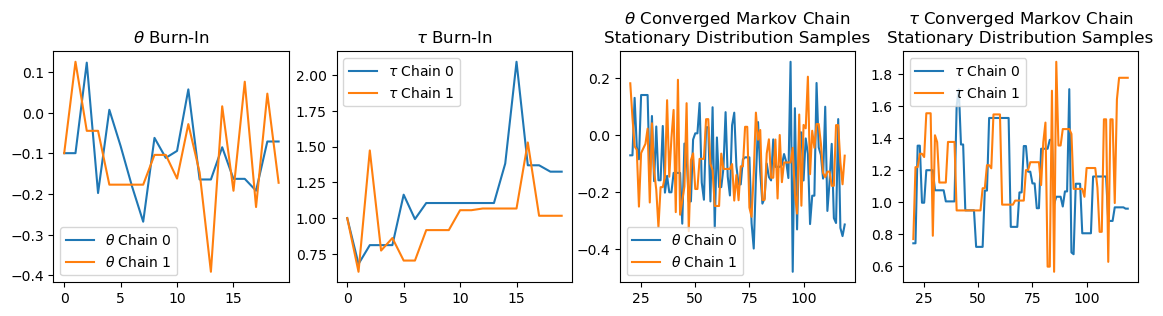

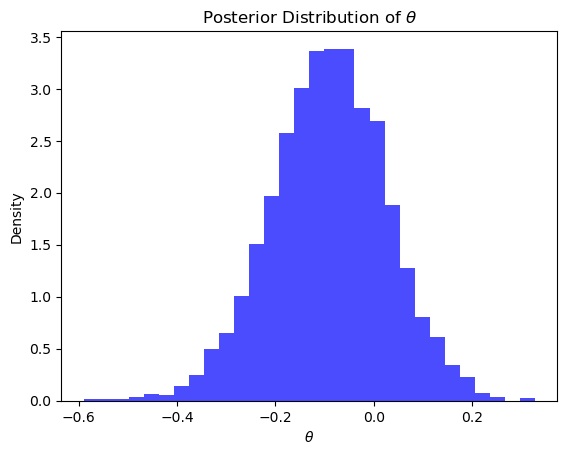

95% credible interval for θ: [-0.32815492  0.1355069 ]


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def adjusted_metropolis_within_gibbs_sampler(n, m, s, C=2, G=5000, burn_in=20):
    x = stats.norm(loc=m, scale=s).rvs(size=n)
    theta, tau = np.zeros([C, G]), np.full([C, G], 1.0)  # Initialize tau with positive values
    theta[:, 0] = np.mean(x)  # Initialization

    for c in range(C):
        for g in range(1, G):
            tau_t_minus_1 = tau[c, g-1]

            # Target distribution (log-scale for stability)
            def log_tau_target(tau_):
                if tau_ <= 0:
                    return -np.inf  # Invalid tau
                log_likelihood = np.sum(stats.norm(loc=theta[c, g-1], scale=1/np.sqrt(tau_)).logpdf(x))
                log_prior = stats.expon(scale=1).logpdf(tau_)
                return log_likelihood + log_prior

            # Dependent proposal distribution for τ (Truncated Normal)
            a, b = -tau_t_minus_1 / s, np.inf
            tau_proposal = stats.truncnorm(a=a, b=b, loc=tau_t_minus_1, scale=s)
            tau_tilde = tau_proposal.rvs()

            # Metropolis-Hastings acceptance probability (log-scale)
            log_mh_ratio = (log_tau_target(tau_tilde) - log_tau_target(tau[c, g-1])) + \
                           (tau_proposal.logpdf(tau[c, g-1]) - tau_proposal.logpdf(tau_tilde))
            acceptance_probability = min(1, np.exp(log_mh_ratio))

            if stats.uniform().rvs() < acceptance_probability:
                tau[c, g] = tau_tilde
            else:
                tau[c, g] = tau[c, g-1]

            # Updating θ with a Laplace prior
            theta_mean = np.mean(x)
            theta_std = (1 / (tau[c, g] * n)) ** 0.5
            theta_prior = stats.laplace(loc=0, scale=1)  # Non-normal prior for θ
            theta_tilde = stats.norm(loc=theta_mean, scale=theta_std).rvs()

            # Metropolis-Hastings step for θ
            log_theta_target = lambda theta_: np.sum(stats.norm(loc=theta_, scale=1/np.sqrt(tau[c, g])).logpdf(x)) + theta_prior.logpdf(theta_)
            mh_theta_ratio = np.exp(log_theta_target(theta_tilde) - log_theta_target(theta[c, g-1]))
            acceptance_probability_theta = min(1, mh_theta_ratio)

            if stats.uniform().rvs() < acceptance_probability_theta:
                theta[c, g] = theta_tilde
            else:
                theta[c, g] = theta[c, g-1]

    # Visualization
    fig, ax = plt.subplots(1, 4, figsize=(14, 3))
    ax[0].set_title("$\\theta$ Burn-In")
    ax[1].set_title("$\\tau$ Burn-In")
    ax[2].set_title("$\\theta$ Converged Markov Chain\nStationary Distribution Samples")
    ax[3].set_title("$\\tau$ Converged Markov Chain\nStationary Distribution Samples")

    demo = 120
    for c in range(C):
        ax[0].plot(theta[c, :burn_in], label=f"$\\theta$ Chain {c}")
        ax[1].plot(tau[c, :burn_in], label=f"$\\tau$ Chain {c}")
        ax[2].plot(np.arange(burn_in, demo), theta[c, burn_in:demo], label=f"$\\theta$ Chain {c}")
        ax[3].plot(np.arange(burn_in, demo), tau[c, burn_in:demo], label=f"$\\tau$ Chain {c}")

    ax[0].legend()
    ax[1].legend()
    ax[2].legend()
    ax[3].legend()
    plt.show()

    plt.hist(theta[0, burn_in:], bins=30, density=True, alpha=0.7, color='blue')
    plt.title("Posterior Distribution of $\\theta$")
    plt.xlabel("$\\theta$")
    plt.ylabel("Density")
    plt.show()

    # 95% credible interval for θ
    credible_interval = np.quantile(theta[0, burn_in:], [0.025, 0.975])
    print(f"95% credible interval for θ: {credible_interval}")

# Run the sampler
adjusted_metropolis_within_gibbs_sampler(n=30, m=0, s=1)


Analytically determining the full confitional distributions in Gibbs sampling is beneficial because it allows for direct sampling from known distributions, leading to faster convergence and efficient computation. However, it is not strictly necessary, espically in complex models where full conditionals are intractable. In these cases, Metropolis within Gibbs provides flexibility by using proposal distributions and acceptance probabilities to sample from complex posteriors. Using both Gibbs sampling and Metropolis allows usuage of Gibbs sampling without the contraint of analytical tractability.

## Q3

Given 

\begin{align*}
\text{Proposal distribution:} && q(\tilde{x}^{(t)} | x^{(t-1)}) &={} \left(\frac{1}{2}\right)^{1-\tilde{x}^{(t)}} \left(\frac{1}{2}\right)^{\tilde{x}^{(t)}}
\end{align*}

This means we propose a new state with equal probability, $q(0\mid 1) = q(1\mid 0) = \frac{1}{2}$.

\begin{align*}
\text{Target (Stationary) distribution:} && p(x^{(t)}) = \left(\frac{1}{3}\right)^{1-x^{(t)}} \left(\frac{2}{3}\right)^{x^{(t)}}
\end{align*}

This means that:
- $p(0) = \frac{1}{3}$
- $p(1) = \frac{2}{3}$

The Metropolis-Hasting Acceptance Probability is:
$$\alpha = \text{min} \left(1, \frac{p(\tilde{x})q(x^{(t-1)}\mid \tilde{x})}{p(x^{(t-1)})q(\tilde{x}\mid x^{(t-1)})}\right)$$

Since the proposal distribution is symmetric, $q(\tilde{x}\mid x) = q(x\mid\tilde{x}) = \frac{1}{2}$, these terms cancel out:
$$\alpha = \text{min}\left(1, \frac{p(\tilde{x})}{p(x^{(t-1)})}\right)$$

Now to compute the transition probability for the Kernal K.

1. $P(0\rightarrow 0): \text{staying in state 0}$
- Proposal is $\tilde{x}=0$ with $q=\frac{1}{2} \rightarrow$ Always accepted since it is the same state.
- Proposal is $\tilde{x}=1$ with $q=\frac{1}{2}$, acceptance probability:
$$\alpha = \text{min} \left(1, \frac{p(1)}{p(0)}\right) = \text{min} \left(1,\frac{2/3}{1/3}\right) = 1$$

So, transition occurs with probability 1. Thus
$$P(0\rightarrow 0) = q(0\mid 0)\cdot 1 + q(1\mid 0)\cdot 0 = \frac{1}{2}$$

2. $P(0\rightarrow 1): \text{Moving from 0 to 1}$
$$P(0\rightarrow 1) = q(0\mid 1)\cdot 1 = \frac{1}{2}$$

3. $P(1\rightarrow 1): \text{Staying in state 1}$
- Proposal $\tilde{x}=1$, accepted with probability 1.
- Proposal $\tilde{x}=0$, acceptance with probability:
$$\alpha = \text{min} \left(1, \frac{p(0)}{p(1)}\right) = \text{min} \left(1,\frac{1/3}{2/3}\right) = \frac{1}{2}$$

Thus:
$$P(1\rightarrow 1) = q(1\mid 1)\cdot 1 + q(0\mid 1)\cdot \left(1-\frac{1}{2}\right) = \frac{1}{2} + \frac{1}{4} = 0.75$$

4. $P(1\rightarrow 0): \text{Moving from 1 to 0}$
$$P(1\rightarrow 0) = q(0\mid 1)\cdot \frac{1}{2} = \frac{1}{4}$$

Final Transition Kernal K:
$$K = \left [\begin{array}{cc} P(0\rightarrow 0) & P(1\rightarrow 0) \\ P(0\rightarrow 1) & P(1\rightarrow 1)  \end{array}\right] = \left [\begin{array}{cc} 0.5 & 0.25 \\ 0.5 & 0.75 \end{array}\right]$$